# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.427908,False,0.826740
1,-3.098414,False,0.914818
2,-1.378408,True,4.901519
3,-1.801252,False,-0.598690
4,-2.062157,False,-0.442767
...,...,...,...
995,-1.631790,False,-0.308988
996,-2.333037,False,-0.266096
997,-0.827494,False,-1.411976
998,0.427173,False,-0.391237


<AxesSubplot: xlabel='v0'>

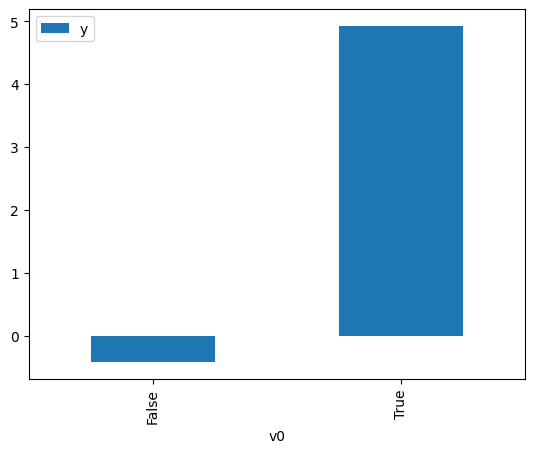

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

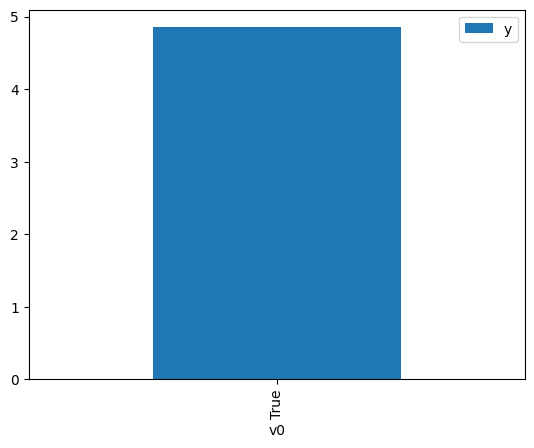

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.627675,False,-0.204526,0.987727,1.012425
1,-0.420912,False,1.508287,0.683522,1.463011
2,-0.752967,False,-1.143819,0.788251,1.268632
3,-1.486314,False,-1.960652,0.925308,1.080722
4,-0.914380,False,-1.743811,0.829070,1.206170
...,...,...,...,...,...
995,-1.501876,False,0.313705,0.927052,1.078688
996,-1.821080,False,-2.691016,0.955451,1.046626
997,0.171829,False,0.051843,0.449719,2.223610
998,-2.090794,False,-1.610544,0.970909,1.029963


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.782157,True,5.123821,0.203871,4.905056
1,0.663530,True,5.431037,0.732621,1.364963
2,-0.093743,True,4.058253,0.441863,2.263144
3,-2.083487,True,5.231844,0.029431,33.977558
4,-0.018318,True,5.665216,0.472542,2.116216
...,...,...,...,...,...
995,-0.809686,True,3.245916,0.196644,5.085343
996,-1.381814,True,2.883144,0.087430,11.437664
997,-0.073098,True,4.657697,0.450226,2.221106
998,-1.603361,True,3.963283,0.062465,16.009015


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.870
Model:                            OLS   Adj. R-squared (uncentered):              0.870
Method:                 Least Squares   F-statistic:                              3336.
Date:                Tue, 06 Dec 2022   Prob (F-statistic):                        0.00
Time:                        05:58:46   Log-Likelihood:                         -1430.1
No. Observations:                1000   AIC:                                      2864.
Df Residuals:                     998   BIC:                                      2874.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4275      0.024     17.749      0.000       0.380       0.475
x2             5.0371      0.063     79.922      0.000       4.913       5.161
==============================================================================
Omnibus:                        8.029   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.544
Skew:                          -0.171   Prob(JB):                       0.0230
Kurtosis:                       2.747   Cond. No.                         2.62
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""